In [124]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from numpy import array
import scipy as sp
import scipy.stats as sps
import math
import matplotlib as mp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import os

#### Asian Call Option

In [125]:
#Consider a stock price driven by a geometric Brownian motion with the following annual parameters:
sigma = 0.4
r = 0.05

def GeomAsianCall(S0,K,r,T,sigma,NSamples):

    dT = T/NSamples;
    nu = r-((1/2)*sigma**2);

    a = np.log(S0)+nu*dT+0.5*nu*(T-dT);
    b = (sigma**2*dT) + ((sigma**2*(T-dT))*(2*NSamples-1)) / (6*NSamples);
    x = (a-np.log(K)+b)/np.sqrt(b);

    N1 = sps.norm.cdf(x)
    N2 = sps.norm.cdf(x-np.sqrt(b))

    P = np.exp(-r*T)*(np.exp(a+b/2)*N1 - K*N2);

    return P

GeomAsian_price = GeomAsianCall(50,55,0.05,1/12,0.40,100)
GeomAsian_price

0.12743640658171163

Text(0.5, 1.0, 'Plot of paths of $S_t$')

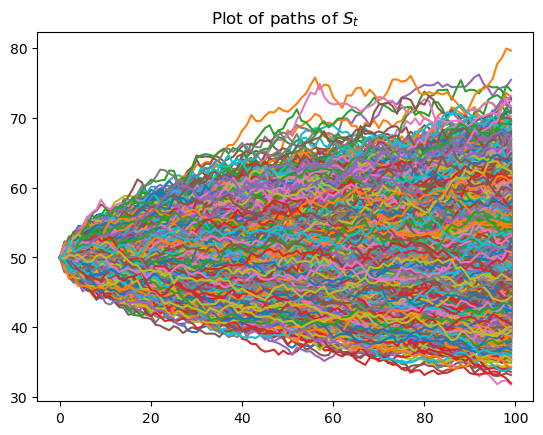

In [126]:
#Function AsianMC(S0,K,r,T,sigma,NSteps,NRepl) returning the price of the asian arithmetic average rate call option by Monte Carlo simulation.
#NRepl is the number of simulations. 
#The output variables represent the option premium P, and the standard error of the mean SE

#Inputs
NSamples=100
NRepl=9000
mu=0.05
sigma=0.4
S0=50
K=55
r=0.05
T=1/12

#Asset Price Path by Monte Carlo
def AssetPaths(S0,mu,sigma,T,NSamples,NRepl):

    ### !!! output, length of path = N
    #code to generate asset price paths by Monte Carlo simulation

    SPaths = np.zeros((NRepl,NSamples));
    SPaths[:,0] = S0;

    dt = T/NSamples;
    nudt = (mu-0.5*sigma**2)*dt;
    sidt = sigma*np.sqrt(dt) ;

    for i in range(0,NRepl):
        for j in range(0,NSamples-1):
            SPaths[i,j+1] = SPaths[i,j]*np.exp(nudt+sidt*np.random.normal(0,1));
    return SPaths

zz=AssetPaths(S0,mu,sigma,T,NSamples,NRepl)
plt.plot(zz.T); plt.title("Plot of paths of $S_t$")

In [127]:
S0 = 50 # Initial asset price
K = 55 # Strike price
r= 0.05 # Risk-free interest rate
T = 1/12 # Time to maturity in years (1 month)
sigma = 0.4 # Volatility
NSteps = 100 # Number of steps
NRepl = 9000 # Number of Monte Carlo simulations


#Asian option pricing - price following a Monte Carlo simulation

#Option1

def AsianMC1(S0,K,r,T,sigma,NSamples,NRepl):
    #Monte Carlo simulation for an Asian option

    Payoff = np.zeros(NRepl);

    for i in range(0, NRepl):
        Path = AssetPaths(S0,mu,sigma,T,NSamples,1);
        Payoff[i] = np.maximum(0,np.mean(Path[0,:])-K);

    p,se = np.mean(np.exp(-r*T)*Payoff), sp.stats.sem(np.exp(-r*T)*Payoff);

    return p,se

premium, se = AsianMC1(S0, K, r, T,sigma, NSteps,NRepl)
print("Asian Arithmetic Average Rate Call Option Premium:", premium)
print("Standard Error of the Mean:", se)

Asian Arithmetic Average Rate Call Option Premium: 0.11549719875186752
Standard Error of the Mean: 0.006107152498131429


In [128]:
#Option2

S0 = 50 # Initial asset price
K = 55 # Strike price
r= 0.05 # Risk-free interest rate
T = 1/12 # Time to maturity in years (1 month)
sigma = 0.4 # Volatility
NSteps = 100 # Number of steps
NRepl = 9000 # Number of Monte Carlo simulations

def AsianMC2(S0, K, r, T, signa, NSteps, NRepl):
  dt = T/NSteps
  nudt = (r - 0.5 * sigma**2) * dt
  sigsdt = sigma * np.sqrt(dt)
  sum_CT = 0
  sum_CT2 = 0

  for i in range (NRepl):
      S = S0
      arithmetic_avg = S0

      for j in range(NSteps):
        epsilon = np. random. normal()
        S *= np.exp(nudt + sigsdt * epsilon)
        arithmetic_avg += S

      arithmetic_avg /= (NSteps + 1)
      CT = max (arithmetic_avg - K, 0)
      sum_CT += CT
      sum_CT2 += CT**2

  premium = np.exp(-r * T) * sum_CT / NRepl
  se = np.sqrt((sum_CT2 - (sum_CT**2) / NRepl) / (NRepl - 1)) / np.sqrt (NRepl)
  return premium, se

premium, se = AsianMC2(S0, K, r, T,sigma, NSteps,NRepl)
print("Asian Arithmetic Average Rate Call Option Premium:", premium)
print("Standard Error of the Mean:", se)

Asian Arithmetic Average Rate Call Option Premium: 0.13266141009949597
Standard Error of the Mean: 0.006707511336384431


In [129]:
AsianMC_output = AsianMC1(S0,K,r,T,sigma,NSamples,NRepl)
p, se = AsianMC_output
print("Premium:", p, "and Std Error:", se)

Premium: 0.13522177614486242 and Std Error: 0.00678540779710003


###### Control variate Method. 

In [130]:
#You would like to price the asian arithmetic average rate call option with maturity 1
#month, strike price K = 55$. Use sample paths with 100 time steps, 9,000 replications, and 1,000 pilot
#replications to compute the control parameter.
#Use the geometric average rate call option as a control variate

In [131]:
"1) Geometric Asian as variate control"

def GeomAsianMCCV(S0,K,r,T,sigma,NSamples,NRepl,NPilot):

    #Monte Carlo simulation with control variates for an Asian option.
    #pilot replications to set control parameter

    samplePath = AssetPaths(S0,r,sigma,T,NSamples,NPilot);

    armean = np.mean(samplePath[:,0:(NSamples)],1)
    geomean = sps.gmean(samplePath[:,0:(NSamples)],1);

    asum =np.sum(samplePath,1)

    VA_hat = np.exp(-r*T)*np.maximum(0,armean-K);
    VB_hats= np.exp(-r*T)*np.maximum(0,geomean-K);
    MatCov = np.cov(VA_hat,VB_hats);

    c = -MatCov[0,1]/np.var(VB_hats);
    dt = T/NSamples;
    VB = GeomAsianCall(S0,K,r,T,sigma,NSamples); #VB is ExpSum

    #MC run

    ControlVars = np.zeros((NRepl,1));
    for i in range(0,NRepl):
        StockPath = AssetPaths(S0,r,sigma,T,NSamples,1);
        Payoff = np.exp(-r*T)*np.maximum(0,np.mean(StockPath[0,0:(NSamples)])-K);
        VBhat_i = np.exp(-r*T)*max(0,np.prod(StockPath[0,:])**(1/NSamples)-K);
        ControlVars[i] = Payoff+c*(VBhat_i-VB);

    p,se = np.mean(ControlVars),sp.stats.sem(ControlVars);
    return p,se

GeomAsianMCCV_output=GeomAsianMCCV(S0,K,r,T,sigma,NSamples,NRepl,1000)
p, se = GeomAsianMCCV_output
print("Premium:", p, "and Std Error:", se)

Premium: 0.1377873527893759 and Std Error: [0.00026298]


In [132]:
#4) #Same question using the average mean of the asset prices as control variate

"Arithmetic Asian with meanS Call as Control Variate"

def AsianMCCV(S0,K,r,T,sigma,NSamples,NRepl,NPilot):

    #Monte Carlo simulation with control variates for an Asian option.
    #pilot replications to set control parameter

    samplePath = AssetPaths(S0,r,sigma,T,NSamples,NPilot);
    armean = np.mean(samplePath[:,0:(NSamples)],1);
    asum =np.sum(samplePath,1)
    
    VA_hat = np.exp(-r*T)*np.maximum(0,armean-K);
    VB_hats = np.exp(-r*T)*asum;
    MatCov = np.cov(VA_hat,VB_hats);

    c = -MatCov[0,1]/np.var(VB_hats);
    dt = T/NSamples;
    VB = S0*(1-np.exp((NSamples+1)*r*dt))/(1-np.exp(r*dt)); #VB is ExpSum

    #MC run
    ControlVars = np.zeros(NRepl);
    for i in range(0,NRepl):
        StockPath = AssetPaths(S0,r,sigma,T,NSamples,1);
        Payoff = np.exp(-r*T)*max(0,np.mean(StockPath[0,])-K);
        ControlVars[i] = Payoff+c*(sum(StockPath[0,])-VB);

    p,se = np.mean(ControlVars),sp.stats.sem(ControlVars);
    return p,se

AsianMCCV_output=AsianMCCV(S0,K,r,T,sigma,12,NRepl,1000)
p, se = AsianMCCV_output
print("AsianCV Arithmetical mean as CV NSamples = 12 \nPremium:", p, "and Std Error:", se, "\n")

AsianMCCV_output=AsianMCCV(S0,K,r,T,sigma,100,NRepl,1000)
p, se = AsianMCCV_output
print("AsianCV Arithmetical mean as CV NSamples = 100 \nPremium:", p, "and Std Error:", se)

AsianCV Arithmetical mean as CV NSamples = 12 
Premium: 0.3788407841995173 and Std Error: 0.004790731832880161 

AsianCV Arithmetical mean as CV NSamples = 100 
Premium: 0.1697354035019892 and Std Error: 0.005466244943829066


In [133]:
#5) #Compute the control variate method in 3 and the crude Monte carlo in 2 using 100,000 replications

#control variate method in 3

NSamples=100
NRepl=100000
NPilot=1000
T=1/12
sigma=0.4
r=0.05
S0=50
K=55

AsianMC_output = AsianMC1(S0,K,r,T,sigma,NSamples,NRepl)
p, se = AsianMC_output
print("Asian MC Premium:", p, "and Std Error:", se)

AsianMCCV_output=AsianMCCV(S0,K,r,T,sigma,NSamples,NRepl,NPilot)
p,se = AsianMCCV_output
print("Asian MC CV-arith Premium:", p, "and Std Error:", se)

GeomAsianMCCV_output=GeomAsianMCCV(S0,K,r,T,sigma,NSamples,NRepl,NPilot)
p, se = GeomAsianMCCV_output
print("Asian MC CV-geom Premium:", p, "and Std Error:", se)

Asian MC Premium: 0.1281334180051082 and Std Error: 0.0019566342241712246
Asian MC CV-arith Premium: 0.18457030656305556 and Std Error: 0.001729669288257649
Asian MC CV-geom Premium: 0.13767895699076013 and Std Error: [7.56514251e-05]


#### Down and Out Put Option

In [134]:
S0     = 50
K      = 50
r      = 0.07
T      = 5/12
sigma  = 0.4
Sb     = 30
NSteps = 100
NRepl  = 1000
Tm     = 2/12

In [135]:
#Down-and-Out put premium.

def DownOutPutMC(S0,K,r,T,sigma,Sb,NSteps,NRepl):

    a = (Sb/S0)**(-1+(2*r/sigma**2));
    b = (Sb/S0)**(1+(2*r/sigma**2));

    d1 = (np.log(S0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T));
    d2 = (np.log(S0/K)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T));
    d3 = (np.log(S0/Sb)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T));
    d4 = (np.log(S0/Sb)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T));
    d5 = (np.log(S0/Sb)-(r-sigma**2/2)*T)/(sigma*np.sqrt(T));
    d6 = (np.log(S0/Sb)-(r+sigma**2/2)*T)/(sigma*np.sqrt(T));
    d7 = (np.log(S0*K/Sb**2)-(r-sigma**2/2)*T)/(sigma*np.sqrt(T));
    d8 = (np.log(S0*K/Sb**2)-(r+sigma**2/2)*T)/(sigma*np.sqrt(T));

    P = K*np.exp(-r*T)*(sps.norm.cdf(d4)-sps.norm.cdf(d2)-a*(sps.norm.cdf(d7)-sps.norm.cdf(d5)))-S0*(sps.norm.cdf(d3)-sps.norm.cdf(d1)-b*(sps.norm.cdf(d8)-sps.norm.cdf(d6)));

    return P

DO_putprice = DownOutPutMC(S0 = 50,K = 50,r = 0.07,T = 5/12,sigma = 0.4,Sb = 30,NSteps = 100,NRepl = 1000)
P = DO_putprice
print("Premium:", P)

Premium: 3.426226320967448


In [136]:
#Modifed-Down-and-Out put premium.

def ModDownOutPutMC(S0,K,r,T,sigma,Sb,NSteps,NRepl,Tm):
    Ntm=round(Tm/T*NSteps)
    Payoff = np.zeros(NRepl);
    for i in range(0,NRepl):
        Path = AssetPaths(S0,r,sigma,T,NSteps,1);
        if np.sum(Path[0,0:Ntm]<=Sb)==0:
            Payoff[i] = max(0,K-Path[0,NSteps-1]);
    p,se = np.mean(np.exp(-r*T)*Payoff),sp.stats.sem(np.exp(-r*T)*Payoff);
    return p,se

MDO_putprice = ModDownOutPutMC(S0 = 50,K = 50,r = 0.07,T = 5/12,sigma = 0.4,Sb = 30,NSteps = 100,NRepl = 1000,Tm=2/12)
p, se = MDO_putprice
print("Premium:", p, "and Std Error:", se)

Premium: 4.386267169939077 and Std Error: 0.18732785074494573
